# Monte Carlo in spinfoams

Description of the notebook

## Setup

In [1]:
using CSV
using DataFrames

using LaTeXStrings

In [2]:
using Statistics
using StatsBase
using StatsPlots

In [3]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box
)
scalefontsizes(1.3)

## Loading Data

Load the data of all the layers

In [4]:
DIRECTORY = "/home/pdona/Desktop/ExportData/data/self_energy/jb_0.5/exact/BF/internal_contributions"
LAYER = Dict()

for k in 0.5:0.5:10.0
    LAYER[k] = DataFrame(
            CSV.File(
                "$(DIRECTORY)/internal_pcutoff_$(k).csv",
                header=false
            ),
        ).Column7
end

Fake MonteCarlo function

In [5]:
function MCSum(vector, Nmc)
    vol = length(vector)
    randomsample = sample(vector,Nmc,replace=true)
    return sum(randomsample)*vol/Nmc
end

MCSum (generic function with 1 method)

In [6]:
exact_layers = [sum(LAYER[k]) for k in 0.5:0.5:10.0];

In [7]:
function relative_error(vector)
    s = std(vector);
    m = mean(vector);
    return 100*s/m
end

relative_error (generic function with 1 method)

# Trials analysis for each layer

We start looking at $10$, $20$, $50$ trials. How can we evaluate what is a good estimate of the error? We look at the boxplot of averages of multiple realizations of $T$ trials

In [9]:
test_10trials = DataFrame();
test_20trials = DataFrame();
test_50trials = DataFrame();

In [8]:
function sample_samples(k,T)
    return [100*(mean([MCSum(LAYER[k],1000) for _ in 1:T])/exact_layers[Integer(2*k)]-1) for _ in 1:100]
end

sample_samples (generic function with 1 method)

In [10]:
test_10trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_10trials[!,"MCestimate"] = vcat([sample_samples(k,10) for k in 5.0:0.5:10.0]...);

test_20trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_20trials[!,"MCestimate"] = vcat([sample_samples(k,20) for k in 5.0:0.5:10.0]...);

test_50trials[!,"Layer"] = vcat([[k for _ in 1:100] for k in 5.0:0.5:10.0]...);
test_50trials[!,"MCestimate"] = vcat([sample_samples(k,50) for k in 5.0:0.5:10.0]...);

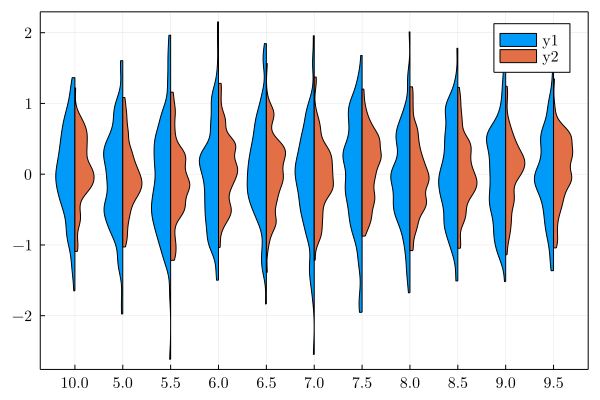

In [11]:
@df test_10trials violin(string.(:Layer),:MCestimate, side = :left)
@df test_20trials violin!(string.(:Layer),:MCestimate,side = :right)

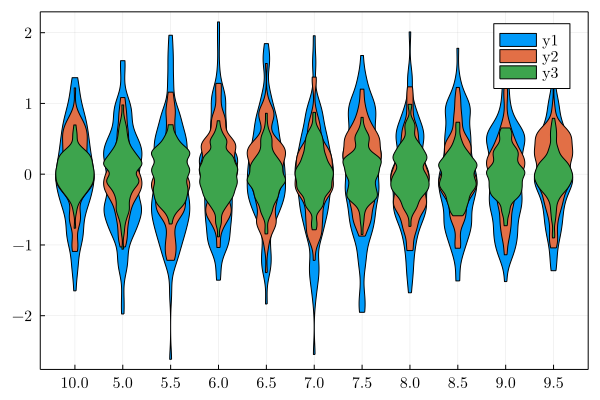

In [12]:
@df test_10trials violin(string.(:Layer),:MCestimate)
@df test_20trials violin!(string.(:Layer),:MCestimate)
@df test_50trials violin!(string.(:Layer),:MCestimate)

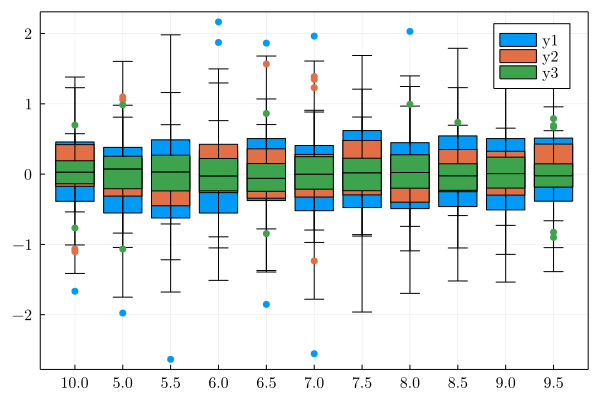

In [13]:
@df test_10trials boxplot(string.(:Layer),:MCestimate)
@df test_20trials boxplot!(string.(:Layer),:MCestimate)
@df test_50trials boxplot!(string.(:Layer),:MCestimate)

Many plots options. We can compare the distribution of the averages using boxplots for which is evident that 10 trials result in a very wide distribution. 20 trials is better and 50 is very narrow. We will settle with 20 for sake of conserving resources. 

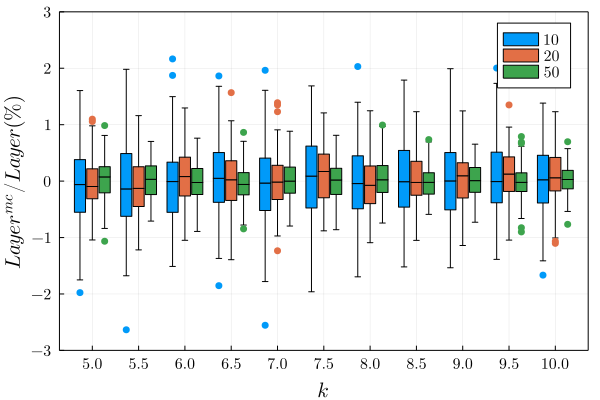

In [44]:
total_df = vcat(test_10trials,test_20trials,test_50trials,source="source");
trialsdict = Dict(1=>10,2=>20,3=>50);
total_df[!,"source"] = [trialsdict[s] for s in total_df[!,"source"]];
boxplots_trials = groupedboxplot(
    string.(total_df.Layer),
    total_df.MCestimate,
    group = total_df.source, 
    bar_position = :dodge,
    xlabel = L"k", 
    ylabel = L"Layer^{mc}/Layer (\%)",
    ylim=(-3,3),
    )

# Decide how many monte carlo samples we take

We compare the results of MC sampling with $N_{mc}=1000$, $N_{mc}=1000$, $N_{mc}=1000$ samples. We compare with the exact result for the amplitude. 
We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation __please upload 10 more__. Then we sum the average value of the layers and we sum variances

**TRIAL 1 IS WRONG**

In [46]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_1.0/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

get_self_energy_exact (generic function with 1 method)

In [78]:
exact_amplitude = get_self_energy_exact().amp[2:end];

In [116]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

In [117]:
relative_Nmc1K = amplitude_Nmc1K./exact_amplitude .-1;
error_relative_Nmc1K = error_Nmc1K./exact_amplitude;

In [118]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc10K = amplitude_Nmc10K./exact_amplitude .-1;
error_relative_Nmc10K = error_Nmc10K./exact_amplitude;

In [119]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc100K = amplitude_Nmc100K./exact_amplitude .-1;
error_relative_Nmc100K = error_Nmc100K./exact_amplitude;

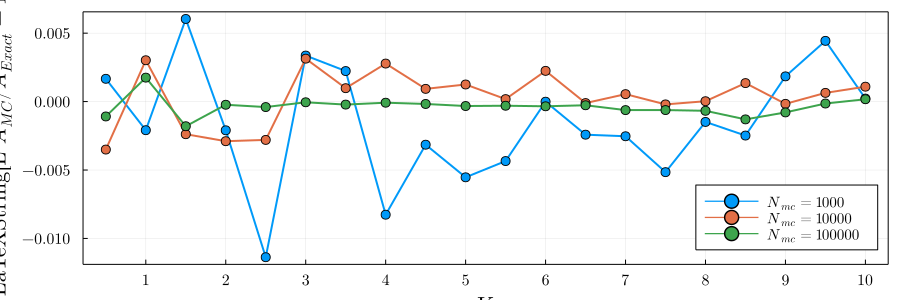

In [133]:
plot_ib0_Nmc= plot(0.5:0.5:10,
               [relative_Nmc1K,relative_Nmc10K,relative_Nmc100K],
               label = [L"$N_{mc}=1000$" L"$N_{mc}=10000$" L"$N_{mc}=100000$"],
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.25),
               size = (900, 300),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
            #    yerror= [error_relative_Nmc1K,error_relative_Nmc10K],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

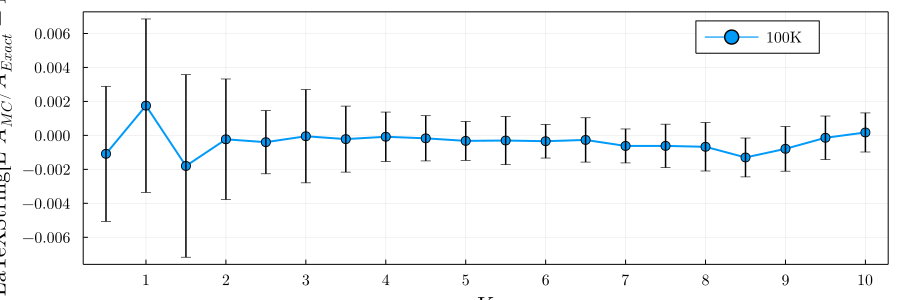

In [129]:
plot_ib0_Nmc= plot(0.5:0.5:10,
               relative_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label = "100K",
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = [L"A_{MC}/A_{Exact} -1"],
               xlabel = "K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )